# SOLVING THE TRANSVERSE ISING MODEL WITH VQE

In this tutorial we show how to solve for the ground state of the __Transverse Ising Model__, arguably one of the most prominent, canonical quantum spin systems, using the __variational quantum eigenvalue solver (VQE)__. 
The VQE algorithm belongs to the class of __hybrid quantum algorithms__ (leveraging both classical as well as quantum compute), that are widely believed to be the working horse for the current __NISQ (noisy intermediate-scale quantum) era__.
To validate our approach we benchmark our results with exact results as obtained from a Jordan-Wigner transformation. 

We provide a step-by-step walkthrough explaining the VQE quantum algorithm and show how to build the corresponding parametrized quantum circuit ansatz using the Braket SDK, with simple modular building blocks (that can be re-used for other purposes). 
While we demonstrate our proof-of-concept approach using classical simulators for circuit execution, our code could in principle be run on actual quantum hardware by simply changing the definition of the ```device``` object.  

## BACKGROUND: THE VARIATIONAL QUANTUM EIGENSOLVER (VQE)

Quantum computers hold the promise to outperform even the most-powerful classical computers on a range of computational problems in (for example) optimization, chemistry, material science and cryptography.
The canonical set of quantum algorithms (such as Shor's or Grover's quantum algorithms), however, comes with hardware requirements (such as a large number of quantum gates) that are currently not available with state-of-the-art technology. 
Specifically, these algorithms are typically believed to be feasible only with fault-tolerance as provided by quantum error correction. 
In the current __noisy intermediate-sclae (NISQ) era__, near-term quantum computers do not have a large enough number of physical qubits for the implementation of error correction protocols, making this canonical set of quantum algorithms unsuitable for near-term devices. Against this background, the near-term focus has widely shifted to the class of __hybrid quantum algorithms__ that do not require quantum error correction. 
In these hybrid quantum algorithms are the noisy __near-term quantum computers are used as co-processors__ only, within a larger classical optimization loop, as sketched in the schematic figure below. 
Here, the undesired effects of noise are suppressed by deliberately limiting the quantum circuits on the quantum processing unit (QPU) to short bursts of the calculation, and the need for long coherence times (as required for the standard set of quantum algorithms) is traded for a classical overhead due to (possibly many) measurement repetitions and (essentially error-free) classical processing. 

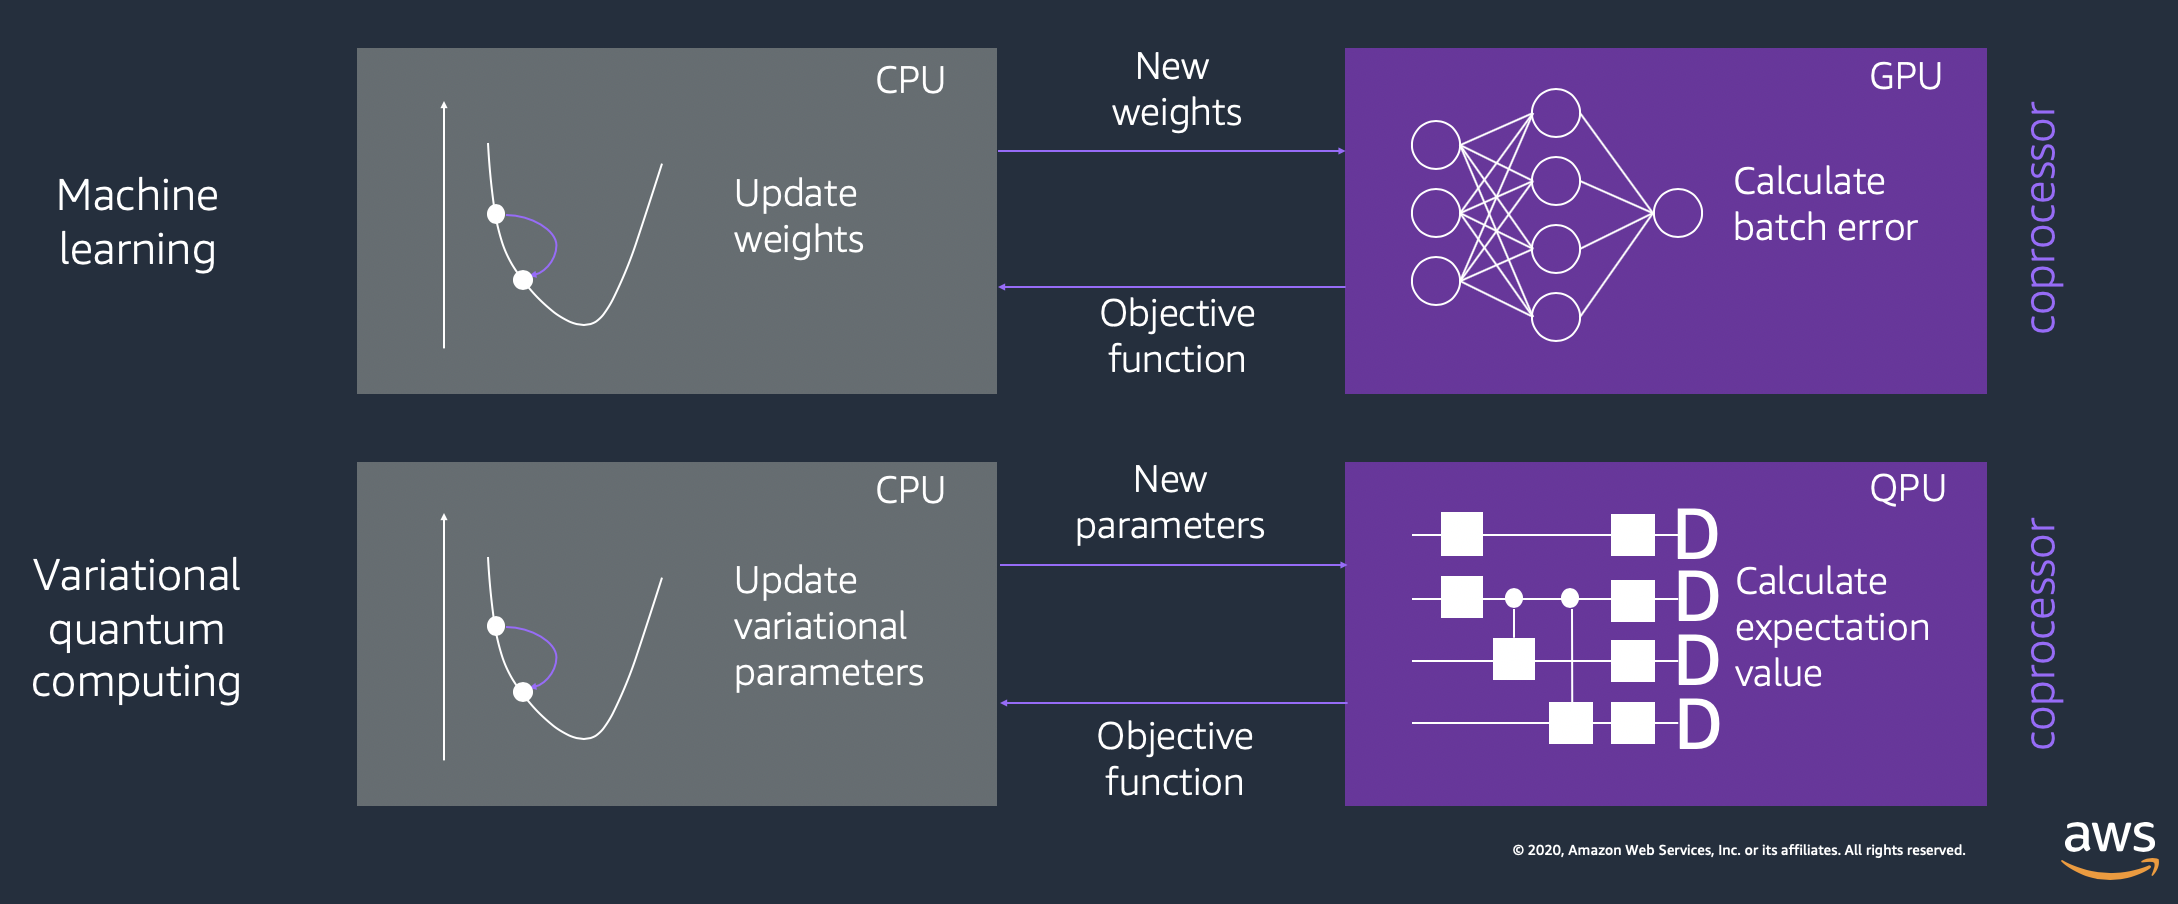

__Variational Quantum Algorithms__: Specifically, variational quantum algorithms such as the Variational Quantum Eigensolver (VQE) [1, 2] or the Quantum Approximate Optimization Algorithm (QAOA) [3] belong to this emerging class of hybrid quantum algorithms. 
These are widely believed to be promising candidates for the demonstration of a __quantum advantage__, already with near-term (NISQ) devices in areas such as quantum chemistry [4], condensed matter simulations [5], and discrete optimization tasks [6].

__Variational Quantum Computing vs. Deep Learning__: The working principle of variational quantum computing is very much reminiscent of training deep neural networks: 
When you train a neural network, you have an objective function that you want to minimize, typically characterized by the error on your training set. 
To minimize that error, typically you start out with an initial guess for the weights in your network. 
The coprocessor, in that case a GPU, takes these weights which define the exact operation to execute and the output of the neural network is computed. 
This output is then used to calculate the value of your objective function, which in turn is used by the CPU to make an educated guess to update the weights and the cycle continues. 
Variational quantum algorithms, a specific form of hybrid algorithms, work in the very same way, using parametrized quantum circuits rather than parametrized neural networks and replacing the GPU with a QPU. 
Here, you start with an initial guess for the parameters that define your circuit, have the QPU execute that circuit, perform measurements to calculate an objective function, pass this value (together with the current values of the parameters) back to the CPU and have this *classical* CPU update the parameters based on that information. 

Of course, coordinating that workflow for quantum computers is much more challenging than in the previous case. Quantum computers are located in specialized laboratory facilities, are typically single threaded, and have special latency requirements. 
This is exactly the undifferentiated heavy-lifting that Amazon Braket takes away for you such that we can focus on our scientific problem. 
For the sake of this introductory tutorial, we simply use a classical circuit simulator (that mimic the behaviour of a quantum machine) as device to execute our quantum circuits.
Within Amazon Braket, the workflow, however, is exactly the same. 

## BACKGROUND: THE TRANSVERSE ISING MODEL

While VQE is a very general approach, for concreteness we will focus on applying VQE to the one-dimensional Transverse Ising Model (TIM). The TIM belongs to a the broader class of many-body spin systems that are inherently hard to study on classical computers as the dimension of the Hilbert space grows exponentially with the number of particles in the system. With the help of a quantum computer, however, we can study these many-body systems with less overhead as the number of qubits required only grows polynomially. Even more so, the specific TIM is an integrable system and can be solved exactly, as shown in [7]. We will use these exact results as a benchmark for our approximate VQE results. 

The transverse field Ising model is a quantum version of the classical Ising model that describes a lattice of spins with nearest neighbour interactions of strength $J$ (as set by the alignment or anti-alignment of spin projections along the $z$ axis), as well as an external magnetic field along the $x$ axis with strength $B$, creating an energetic bias for one x-axis spin direction over the other. 

In one dimension, the Hamiltonian describing the TIM for $N$ spin-$1/2$ particles reads: 

$$H = -J\sum_{i}S_{i}^{z}S_{i+1}^{z} - B\sum_{i}S_{i}^{x}.$$
Transforming the spin variables to qubits, we obtain:
$$H = -\frac{1}{4}\sum_{i}\sigma_{i}^{z}\sigma_{i+1}^{z} - \frac{B}{2}\sum_{i}\sigma_{i}^{x}.$$

Here, $B$ denotes the strength of the transverse magnetic field (in units of the hopping matrix element $J$ that we have set to unity). 

__Symmetries and Phases__: The Hamiltonian $H$ possesses a $\mathbb{Z}_{2}$ symmetry, as it is invariant under the unitary transformation of flipping all qubits along the $z$-direction by an angle of $\pi$. Formally, this property can be expressed as $R_{x}HR_{x}^{\dagger}=H$, since $R_{x}\sigma_{i}^{z}R_{x}^{\dagger}=-\sigma_{i}^{z}$ and $R_{x}\sigma_{i}^{x}R_{x}^{\dagger}=\sigma_{i}^{x}$, with $R_{x}=\exp(-i \pi/2 \sum_{i}\sigma_{i}^{x})= (-i)^{N}\prod _{i}\sigma_{i}^{x}$ being a global rotation around the $x$-axis by angle $\pi$. 
The 1D model then allows for two phases, depending on whether the ground state $\left|\Psi_{\mathrm{gs}}\right>$ breaks or preserves this global spin-flip symmetry [8]: 
* *Ordered Phase*: When the transverse field $B$ is small, the system is in the ordered phase. In this phase the ground state breaks the spin-flip symmetry. Thus, the ground state is in fact two-fold degenerate.
Mathematically, if ${\displaystyle |\psi _{1}\rangle }$  is a ground state of the Hamiltonian, then ${\displaystyle |\psi _{2}\rangle \equiv \prod \sigma^{x}_{j}|\psi _{1}\rangle \neq |\psi _{1}\rangle }$ is a ground state as well. Taken together, these two distinct states span the degenerate ground state space. 
Consider the following example for $B=0$: In this case, the ground state space is spanned by the states ${\displaystyle |\ldots 1,1,1, \ldots \rangle }$ and ${\displaystyle |\ldots 0,0,0, \ldots \rangle }$, that is, with all the qubits aligned along the $z$ axis.
* *Disordered Phase*: In contrast, when $B>1$, the system is in the disordered phase. Here, the ground state *does* preserve the spin-flip symmetry, and is nondegenerate (as opposed to the ordered phase discussed above). 
Consider the following example when $B \rightarrow \infty$: Here, the ground state is simply the state aligned with the external magnetic field, ${\displaystyle |\ldots +,+,+, \ldots \rangle}$, with every qubit (spin) pointing in the $x$ direction.

There is a quantum phase transition at $B=1$ separating these two phases. 

## IMPORTS and SETUP

In [1]:
# general imports
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time
from datetime import datetime
# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# Ensure consistent results
np.random.seed(0)

# Flag to trigger writing results plot to file
SAVE_FIG = False

In [3]:
# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, AngledGate, QubitSet
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsSession

__NOTE__: Please enter your desired device and S3 location (bucket and key) below. If you are working with the local simulator ```LocalSimulator()``` you do not need to specify any S3 location. However, if you are using the managed cloud-based device or any QPU devices you need to specify the S3 location where your results will be stored. In this case, you need to replace the API call ```device.run(circuit, ...)``` below with ```device.run(circuit, s3_folder, ...)```. 

In [4]:
# Set up device: Local Simulator
device = LocalSimulator()

# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = f"amazon-braket-Your-Bucket-Name" # the name of the bucket
my_prefix = "Your-Folder-Name" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [5]:
## example code for other backends
## choose the cloud-based managed simulator to run your circuit
# device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
## choose the Rigetti device to run your circuit
# device = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-8")
## choose the Ionq device to run your circuit
# device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")

## PROBLEM SETUP

In this section we develop a set of useful helper functions that we will explain in detail below. 
Specifically we provide simple building blocks for the core modules of our VQE algorithm, that is (i) a function called ```circuit``` that defines the parametrized ansatz, (ii) a function called ```objective_function``` that takes a list of variational parameters as input, and returns the cost associated with those parameters and finally (iii) a function ```train``` to run the entire VQE algorithm for given ansatz. 
This way we can solve the problem in a clean and modular approach.

In [6]:
# helper function to set up interaction term
def get_ising_interactions(n_qubits):
    """
    function to setup Ising interaction term
    """
    # set number of qubits
    ising = np.zeros((n_qubits, n_qubits))
    # set nearest-neighbour interactions to nonzero values only
    for ii in range(0, n_qubits-1):
        ising[ii][ii+1] = -1
    # add periodic boundary conditions
    ising[0][n_qubits-1] = -1
    print('Ising matrix:\n', ising)
    
    return ising

In [7]:
# function to build the VQE ansatz
def circuit(params, n_qubits):
    """
    function to return full VQE circuit ansatz
    input: parameter list with three parameters 
    """

    # instantiate circuit object
    circuit = Circuit()
    
    # add Hadamard gate on first qubit
    circuit.rz(0, params[0]).ry(0, params[1])

    # apply series of CNOT gates
    for ii in range(1, n_qubits):
        circuit.cnot(control=0, target=ii)

    # add parametrized single-qubit rotations around y
    for qubit in range(n_qubits):
        gate = Circuit().ry(qubit, params[2])
        circuit.add(gate)

    return circuit


# function that computes cost function for given params
def objective_function(params, b_field, n_qubits, n_shots, s3_folder, verbose=False):
    """
    objective function takes a list of variational parameters as input,
    and returns the cost associated with those parameters
    """
    
    global CYCLE
    CYCLE += 1
    
    if verbose:
        print('==================================' * 2)
        print('Calling the quantum circuit. Cycle:', CYCLE)
    
    # obtain a quantum circuit instance from the parameters
    vqe_circuit = circuit(params, n_qubits)
    
    # Computations are independent of one another, so can be triggered in parallel
    # run the circuit on appropriate device
    if device.name == 'DefaultSimulator':
        task_zz = device.run(vqe_circuit, shots=n_shots)
    else: 
        task_zz = device.run(vqe_circuit, shots=n_shots, 
                             s3_destination_folder=s3_folder, poll_timeout_seconds=3*24*60*60)

    # Hb term: construct the circuit for measuring in the X-basis
    H_on_all = Circuit().h(range(0, n_qubits))
    vqe_circuit.add(H_on_all)
    
    # run the circuit (with H rotation at end)
    if device.name == 'DefaultSimulator':
        task_b = device.run(vqe_circuit, shots=n_shots)
    else:
        task_b = device.run(vqe_circuit, shots=n_shots, 
                     s3_destination_folder=s3_folder, poll_timeout_seconds=3*24*60*60)

    # Collect results from devices (wait for results, if necessary)
    result_zz = task_zz.result()
    result_b = task_b.result()
    
    # Compute Hzz term
    # convert results (0 and 1) to ising (1 and -1)
    meas_ising = result_zz.measurements
    meas_ising[meas_ising == 1] = -1
    meas_ising[meas_ising == 0] = 1
    
    # Hzz term: get all energies (for every shot): (n_shots, 1) vector
    all_energies_zz = np.diag(np.dot(meas_ising, np.dot(J, np.transpose(meas_ising))))
    
    # Hzz term: get approx energy expectation value (factor 1/4 for Pauli vs spin 1/2) 
    energy_expect_zz = 0.25*np.sum(all_energies_zz)/n_shots
    
    # Compute Hb term
    # convert results (0 and 1) to ising (1 and -1)
    meas_ising = result_b.measurements
    meas_ising[meas_ising == 1] = -1
    meas_ising[meas_ising == 0] = 1
    
    # Hb term: get all energies (for every shot): (n_shots, 1) vector
    # factor 1/2 for Pauli vs spin 1/2
    energy_expect_b = -1*b_field/2*meas_ising.sum()/n_shots
    
    # get total energy expectation value
    energy_expect = energy_expect_zz + energy_expect_b
    # per site
    energy_expect_ind = energy_expect/n_qubits
    
    # print energy expectation value
    if verbose:
        print('Energy expectation value:', energy_expect)
        print('Energy expectation value (per particle):', energy_expect_ind)

    return energy_expect


# The function to execute the training: run classical minimization.
def train(b_field, options, n_qubits, n_shots, n_initial=10, s3_folder=None, verbose=False):
    """
    function to run VQE algorithm with several random seeds for initialization
    """
    print('Starting the training.')
    
    if verbose:
        print('==================================' * 3)
        print('Running VQE OPTIMIZATION.')
    
    # initialize vectors for results per random seed
    cost_energy = []
    angles = []
    
    # optimize for different random initializations: avoid local optima
    for ii in range(n_initial):
        
        #print counter
        if verbose:
            run_init = ii+1
            print('Running VQE OPTIMIZATION for random seed NUMBER', run_init)
        
        # randomly initialize variational parameters within appropriate bounds
        params0 = np.random.uniform(0, 2 * np.pi, 3).tolist()
        # set bounds for search space
        bnds = [(0, 2 * np.pi) for _ in range(int(len(params0)))]

        # run classical optimization
        result = minimize(objective_function, params0, args=(b_field, n_qubits, n_shots, s3_folder, verbose), 
                          options=options, method='SLSQP', bounds=bnds)

        # store result of classical optimization
        result_energy = result.fun
        cost_energy.append(result_energy)
        result_angle = result.x
        angles.append(result_angle)
        if verbose:
            print('Optimal avg energy:', result_energy)
            print('Optimal angles:', result_angle)
        
        # reset cycle count 
        global CYCLE
        CYCLE = 0
    
    # store energy minimum (over different initial configurations)
    energy_min = np.min(cost_energy)
    optim_angles = angles[np.argmin(cost_energy)]
    if verbose:
        print('Energy per initial seeds:', cost_energy)
        print('Minimal energy:', energy_min)
        print('Optimal variational angles:', optim_angles)
    
    return energy_min

## Illustration of the VQE ansatz

__VQE ansatz__: VQE tries to find the lowest energy configuration of a given Hamiltonian, such as that of a chemical system or some many-body spin system (as studied here). Being a variational quantum-classical algorithm, VQE uses the QPU for state preparation and measurement subroutines, and the classical computer to post-process the measurement results and update the parametrized VQE ansatz according to an update rule such as gradient descent.
VQE, however, does not come without limitations. 
Akin to what happens in deep learning, the quality of our results will depend very much on the trial architecture of our circuit (i.e., the trial wave function) and its the expressive power. 
In other words, to *approximate* the ground state we are looking for, VQE can only operate within the bounds of the general ansatz we are using (the so-called ansatz space), by having a quantum computer prepare this very ansatz state with a parameterized gate sequence, and then have a classical optimizer iteratively update the optimal parameters. 
Here, we will be guided by physical intuition and symmetry arguments to make an educated guess for our variational ansatz. 

In general, VQE makes us of the variational principle, by preparing a parametrized trial wavefunction $\left|\Psi(\vec{\theta})\right>$, and trying to find the optimal set of parameters $\vec{\theta}^{*}$, according to the following objective 
$$\mathrm{min} \left<\Psi(\vec{\theta})|H|\Psi(\vec{\theta})\right> \geq E_{0}.$$

Here, $E_{0}$ denotes the (true) lowest energy eigenvalue of the Hamiltonian $H$. 
Since (for sufficiently large systems with more than $\sim 50$ qubits) classical computers are unable to efficiently prepare, store and measure the wavefunction, we use the quantum computer for this subroutine. 
We then use the classical computer to iteratively update the parameters using some optimization algorithm [9].

__VQE ansatz for TIM__: Next, we need to choose an ansatz appropriate for the system under study, the Transverse Ising Model (TIM). 
We use an ansatz that can account for quantum entanglement. 
Because of the $\mathbb{Z}_{2}$ symmetry discussed above, for any given state $\left|\Psi(\theta)\right>$ the rotated state $R_{x}\left|\Psi(\theta)\right>$ is a degenerate state with the same energy. 
Therefore, we take our ansatz as a linear superposition of these two degenerate states, $\left|\psi(\theta)\right> = \alpha \left|\Psi(\theta)\right> + \beta R_{x}\left|\Psi(\theta)\right>$. How can we prepare such a state on a quantum computer? We use the following sequence of parametrized gates [10]: 

First, starting from $\left|0000\right>$ we apply a general single qubit rotation to the first qubit to obtain the state 

$$\left|000\dots\right> \rightarrow \alpha \left|000\dots\right> + \beta \left|100\dots\right>,$$ 

where the parameters $\alpha, \beta$ can be learned in the training process. 
Then, we apply a sequence of CNOT gates as is done for the preparation of GHZ states. 
The first CNOT between the first and second qubits prepares the state 

$$\alpha \left|000\dots\right> + \beta \left|110\dots\right>.$$

We continue with CNOT gates till we arrive at the parametrized ansatz

$$\alpha \left|000\dots\right> + \beta \left|111\dots\right>.$$

Finally, to account for different polarization directions we apply parametrized single qubit rotations around the $y$ axis to arrive at our VQE trial ansatz state 

$$\left|\Psi(\theta)\right> = \alpha U_{y}(\theta_{y})\left|000\dots\right> + \beta U_{y}(\theta_{y})\left|111\dots\right>,$$

with $U_{y}(\theta_{y})=\prod \exp(-i \theta_{y}/2 \sigma_{i}^{y})$.

__Illustration__: Below, we illustrate our ansatz (as prepared by our method ```circuit```) with a circuit diagram for a small number of qubits $N$ and a fixed set of classical parameters. We print both our VQE ansatz as well as the modified circuit with a layer of single-qubit Hadamard gates ```H``` attached at the end, as needed to measure the $x$ projection with $\sigma_{i}^{x}$ for all qubits. The latter is needed to compute the expectation value for the transverse field term $H_{B}=(B/2)\sum_{i}\sigma_{i}^{x}$. With this simple visualization we can convince ourselves that we have implemented the circuit ansatz as desired.  

In [8]:
# visualize VQE circuit example
N = 4
params = [0.1, 0.2, 0.3]

vqe_circuit = circuit(params, N)

print('1. Printing VQE test circuit:')
print(vqe_circuit)

# Hb term: construct the circuit for measuring in the X-basis
print('')
print('2. Apply Hadamard to measure in x-basis:')
H_on_all = Circuit().h(range(0, N))
vqe_circuit.add(H_on_all)
print(vqe_circuit)

1. Printing VQE test circuit:
T  : |   0   |   1   |2|    3    |    4    |   5   |
                                                    
q0 : -Rz(0.1)-Ry(0.2)-C-C---------C---------Ry(0.3)-
                      | |         |                 
q1 : -----------------X-|-Ry(0.3)-|-----------------
                        |         |                 
q2 : -------------------X---------|-Ry(0.3)---------
                                  |                 
q3 : -----------------------------X---------Ry(0.3)-

T  : |   0   |   1   |2|    3    |    4    |   5   |

2. Apply Hadamard to measure in x-basis:
T  : |   0   |   1   |2|    3    |    4    |   5   |6|
                                                      
q0 : -Rz(0.1)-Ry(0.2)-C-C---------C---------Ry(0.3)-H-
                      | |         |                   
q1 : -----------------X-|-Ry(0.3)-|-H-----------------
                        |         |                   
q2 : -------------------X---------|-Ry(0.3)-H---------
            

## VQE SIMULATION ON LOCAL SIMULATOR

We are now ready to run some VQE simulation experiments. First of all, you can play and experiment yourself with the number of qubits $N$. Secondly, you may also experiment with the classical optimizer. Since we are using an off-the-shelf ```scipy``` minimizer (as described in more detail [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)), you can simply swap between different optimizers by setting the ```method``` parameter accordingly, as done above in the line ```result = minimize(..., method='SLSQP')```. Some popular options readily available within this library include *Nelder-Mead*, *BFGS* and *COBYLA*.    
As a precautionary warning, note that the classical optimization step may get stuck in a local optimum, rather than finding the global minimum for our parametrized VQE ansatz wavefunction. 
To address this issue, we run several optimization loops, starting from different random parameter seeds. 
You can set the number of these optimization loops using the ```n_initial``` parameter, as shown below. 
While this brute-force approach does not provide any guarantee to find the global optimum, from a pragmatic point of view at least it does increase the odds of finding an acceptable solution, at the expense of potentially having to run many more circuits on the QPU.
For a more detailed and sophisticated discussion of classical optimization of VQE we refer to Ref.[11]. 

In [9]:
# set up the problem
SHOTS = 1000
N = 10 # number of qubits
n_initial = 30 # number of random seeds to explore optimization landscape
verbose = False # control amount of print output

# set counters
CYCLE = 0

# set up Ising matrix with nearest neighbour interactions and PBC
J = get_ising_interactions(N)

# set options for classical optimization
if verbose:
    options = {'disp': True}
else: 
    options = {}

# kick off training
start = time.time()

# parameter scan
stepsize = 0.5
xvalues = np.arange(0, 2+stepsize, stepsize)
results = []
results_site = []

for bb in xvalues:
    b_field = bb
    print('Strength of magnetic field:', b_field)
    energy_min = train(b_field, options=options, n_qubits=N, n_shots=SHOTS, n_initial=n_initial, 
                       s3_folder=s3_folder, verbose=verbose)
    results.append(energy_min)
    results_site.append(energy_min/N)
    
    # reset counters
    CYCLE = 0

end = time.time()
# print execution time
print('Code execution time [sec]:', end - start)

# print optimized results
print('Optimal energies:', results)
print('Optimal energies (per site):', results_site)

Ising matrix:
 [[ 0. -1.  0.  0.  0.  0.  0.  0.  0. -1.]
 [ 0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Strength of magnetic field: 0.0
Starting the training.
Strength of magnetic field: 0.5
Starting the training.
Strength of magnetic field: 1.0
Starting the training.
Strength of magnetic field: 1.5
Starting the training.
Strength of magnetic field: 2.0
Starting the training.
Code execution time [sec]: 50.120402097702026
Optimal energies: [-2.498, -2.9795, -4.5729999999999995, -7.1125, -9.302999999999999]
Optimal energies (per site): [-0.24980000000000002, -0.29795, -0.45729999999999993, -0.7112499999999999, -0.9302999999999999]


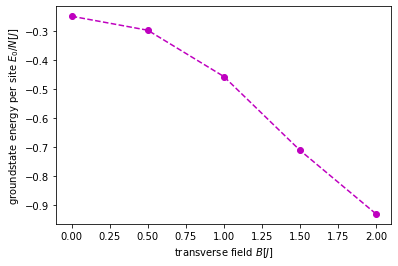

In [10]:
# plot the VQE results for the energy per site
plt.plot(xvalues, results_site, 'm--o')
plt.xlabel('transverse field $B [J]$')
plt.ylabel('groundstate energy per site $E_{0}/N [J]$')
plt.show()

## BENCHMARKING OUR VQE ANSATZ WITH EXACT RESULTS

As detailed in the seminal paper by [7], the paradigmatic TIM can be solved with the help of a (highly non-local) Jordan-Wigner transformation that expresses the spin (qubit) variables as fermionic variables, and leading to a sum of local quadratic terms containing fermionic creation and annihilation operators. 
The resulting Hamiltonian is mathematically identical to that of a superconductor in the mean field Bogoliubov deGennes formalism and can be completely understood in the same standard way. 
Specifically, the exact excitation spectrum and eigenvalues can be determined by Fourier transforming into momentum space and diagonalizing the Hamiltonian. 

Here, we just use the known results from Ref.[7] to recover the exact ground-state energy with the helper function defined below, and refer the interested reader to the broad set of literature on the TIM for further details. The original paper is available [online here](https://www.math.ucdavis.edu/~bxn/pfeuty1970.pdf). 

In [11]:
# helper function to numerically solve for gs energy of TIM
def num_integrate_gs(B):
    """
    numerically integrate exact band to get gs energy of TIM
    this should give -E_0/(N*J) by Pfeufy
    Here set J=1 (units of energy)
    """
    # lamba_ratio (setting J=1): compare thesis
    ll = 1/(2*B)
    
    # set energy
    gs_energy = 0
    
    # numerical integration
    step_size = 0.0001
    k_values = np.arange(0, np.pi, step_size)
    integration_values = [step_size*np.sqrt(1 + ll**2 + 2*ll*np.cos(kk)) for kk in k_values]
    integral = np.sum(integration_values)
    gs_energy = 1*integral/(4*np.pi*ll)
    
    return gs_energy

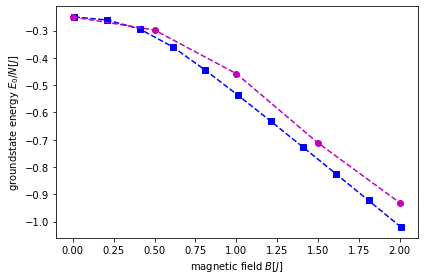

In [12]:
# plot exact gs energy of TIM vs VQE results
x = np.arange(0.01, 2.2, 0.2)
y = [-1*num_integrate_gs(xx) for xx in x]
# plot exact results
plt.plot(x, y, 'b--s')
# plot vqe results
plt.plot(xvalues, results_site, 'm--o')
plt.xlabel('magnetic field $B [J]$')
plt.ylabel('groundstate energy $E_{0}/N [J]$')
plt.tight_layout();
# save figure
if SAVE_FIG:
    time_now = datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
    filename = 'vqe_tim_gs-energy_'+time_now+'.png'
    plt.savefig(filename, dpi=700);

As shown above, for sufficiently large number of seeds (```n_initial```) we approximate the exact results reasonably well with our relatively simple three-parameter VQE ansatz, in the whole magnetic field region under consideration. 

---
## REFERENCES

[1] A. Peruzzo, J. McClean, P. Shadbolt, M.-H. Yung, X.-Q. Zhou, P. J. Love, A. Aspuru-Guzik, and J. L. Obrien, Nature communications 5, 56 (2014).

[2] J. R. McClean, J. Romero, R. Babbush, and A. Aspuru-Guzik, *The theory of variational hybrid quantum-classical algorithms*, New Journal of Physics 18, 023023 (2016).

[3] E. Farhi, J. Goldstone, and S. Gutmann, arXiv 1411.4028 (2014).

[4] Y. Cao, J. Romero, J. P. Olson, M. Degroote, P. D. Johnson, M. Kieferov´a, I. D. Kivlichan, T. Menke, B. Peropadre, N. P. Sawaya, et al., Chemical reviews 119,
10856 (2019).

[5] A. Smith, M. Kim, F. Pollmann, and J. Knolle, npj
Quantum Information 5, 1 (2019).

[6] L. Zhou, S.-T. Wang, S. Choi, H. Pichler, and M. D.
Lukin, arXiv 1812.01041 (2018). 

[7] P. Pfeuty, *The One-Dimensional Ising Model with a Transverse Field*, Annals of Physics __57__, 79-90 (1970). 

[8] https://en.wikipedia.org/wiki/Transverse-field_Ising_model

[9] S. McArdle, S. Endo, A. Aspuru-Guzik, S. Benjamin, X. Yuan, *Quantum computational chemistry*, Rev. Mod. Phys. 92, 15003 (2020). 

[10] Abhijith J. *et al.*, *Quantum Algorithm Implementations for Beginners*, arXiv:1804.03719 (2018). 

[11] D. Wierichs, C. Gogolin, M. Kastoryano, *Avoiding local minima in variational quantum eigensolvers with the natural gradient optimizer*, arXiv:2004.14666 (2020). 

---
## APPENDIX

In [13]:
# Check SDK version
!pip show amazon-braket-sdk | grep Version

Version: 0.6.0
